# Case Study: 2017 Northern Plains Flash Drought

In [ ]:
import earthaccess
import numpy as np
import xarray as xr
import pandas
from matplotlib import pyplot

auth = earthaccess.login()

## Before We Get Started

For this case study, we're going to download some data from [the North American Land Data Assimilation System (NLDAS).](https://disc.gsfc.nasa.gov/datasets/NLDAS_NOAH0125_M_2.0/summary?keywords=NLDAS)

Consequently, we'll need a place to store these raw data. It's important that we have a folder in our file system reserved for these raw data so we can keep them separate from any new datasets we might create. 

**Let's create a folder called `data_raw` in our Jupyter Notebook's file system.**

We should never modify the raw data (that we're about to download). Doing so would make it hard to repeat the analysis we're going to perform as we will lose the original data values. This doesn't mean we have to keep the `data_raw` folder around forever: if it's publicly available data, we can always download it again.

---

## Downloading the Data

We'll use the function `earthaccess.search_data()` again. In this case, the `short_name` and `version` can be found on [the Goddard Earth Sciences (GES) Data and Information Services Center (DISC) website for this product.](https://disc.gsfc.nasa.gov/datasets/NLDAS_NOAH0125_M_2.0/summary?keywords=NLDAS)

**The NLDAS data we're interested in are compiled monthly and we want to download an August monthly dataset for each year.** Because the dates we want are non-consecutive, we need to call `earthaccess.search_data()` within a `for` loop. Below, we also use string formatting so that the string `f'{year}-08'` becomes, e.g.: `'2008-08'`, `'2009-08'`, and so on.

In [ ]:
# Instructor: Show how to find the "short_name" and "version"

results = []

for year in range(2008, 2018):
    search = earthaccess.search_data(
        short_name = 'NLDAS_NOAH0125_M',
        version = '2.0',
        temporal = (f'{year}-08', f'{year}-08'))
    results.extend(search)

In [ ]:
len(results)

Previously, we've used `earthaccess.open()` to get access to these data. This time, we'll use `earthaccess.download()`. What's the difference?

- `earthaccess.open()` provides a file-like object that is available to be downloaded and read *only we need it.*
- `earthaccess.download()` actually downloads the file to our file system.

**Note that, below, we're telling `earthaccess.download()` to put the downloaded files into our new `data_raw` folder.**

In [ ]:
earthaccess.download(results, 'data_raw')

In [ ]:
import glob

file_list = glob.glob('data_raw/*.nc')
file_list.sort()
file_list

**These NLDAS files contain multiple different variables...**

In [ ]:
# Open just the first file
ds = xr.open_dataset(file_list[0])
ds

**In this case study, we're primarily interested in the variables that quantify the state of the water cycle or evaporative stress:**

- `Evap`: This is total evapotranspiration
- `SWdown`: Down-welling short-wave radiation, i.e., the amount of solar radiation directed downwards
- `SMAvail_0_100cm`: The total liquid water in the top 100 cm of soil

### netCDF4 Files

One of the nice things about Network Common Data Format (netCDF) files is that they are *self-documenting;* they can contain multiple datasets, organized hierarchically, with documentation at both the dataset and the file level.

The **file-level metadata** can be see in the "Attributes" of the file, below:

In [ ]:
ds

**Or directly accessed:**

In [ ]:
ds.attrs

**In addition `xarray`, the `netCDF4` library in Python also allows us to open netCDF4 files.** There are some important differences to be aware of...

First, file-level metadata is accessed like this:

In [ ]:
import netCDF4

nc = netCDF4.Dataset(file_list[0])
nc.ncattrs()

### Getting Real Values from netCDF4 Datasets

Another important difference is how array data are read from the files.

The `netCDF4` package reads array data from the file the way it is stored on disk.

In [ ]:
nc.variables['Evap']

**Notice the `scale_factor`, `add_offset`, and `missing_value` attributes.** These are very important to consider because of the way netCDF4 files sometimes store variables. If the variables are packed in a certain way to save disk space, we need to transform the packed values into real values before using the data:

$$
\text{Real value} = (\text{Packed value}\times \text{Scale factor}) + \text{Offset}
$$

**When we look at the `"Evap"` (total evapotranspiration) dataset's attributes with `xarray`, however...**

In [ ]:
et = ds.variables['Evap']
et.attrs

**Note that the attributes are different!** The `scale_factor`, `add_offset`, and `missing_value` attributes are missing.

**This is because `xarray` transforms packed values into real values automatically for us.** Compare the two examples below.

In [ ]:
np.array(nc.variables['Evap'][:])

In [ ]:
np.array(ds.variables['Evap'][:])

**In this case, the `scale_factor` is `1.0` and the `add_offset` is `0.0`, meaning the packed values are the same as the real values.** Hence, there is no difference in the numbers for valid data areas, above; but we can see that the `xarray.Dataset` replaced the `missing_value` (-9999) with `np.nan`.

### Plotting netCDF4 Variables

Let's plot the data from the first monthly dataset (August 2008). **Recall that, when using `pyplot.imshow()`, we have to provide a 2D array...**

In [ ]:
et = nc.variables['Evap']

et.shape

The first axis of our `et` array is trivial, as it has only one element. We can simply subset the `et` array to this "first" (and only) element using `et[0]`:

In [ ]:
pyplot.imshow(et[0])

Does this look right? Why is it upside down?

The reason is because of [the CF Convention](http://cfconventions.org/) that defines how netCDF4 files should be formatted. Part of that standard requires that the coordinate arrays (here, latitude and longitude arrays) be sorted from smallest number to largest number. **Whereas spatial coordinate systems like latitude-longitude have numbers increasing from bottom-to-top and left-to-right, image coordinate systems (for arrays) differ in that numbers increase from top-to-bottom:**

![](assets/coordinate-system-diagram.png)

When working with a coordinate system that uses latitude, that means that the vertical coordinates go from the most southern (negative) latitude to the most northern (positive) latitude. **Essentially, are image is flipped upside-down because the most negative coordinates are at the top of the image.** We can easily flip an array right-side up using `np.flipud()` ("flip upside-down"):

In [ ]:
pyplot.imshow(np.flipud(et[0]))

In [ ]:
# TODO Note data type, why we're changing it to an array

type(et)

### Opening netCDF4 Files with `xarray`

A big advantage to using `xarray` is how it organizes all the information we're interested in. Recall that `xarray` variables can be accessed using a dictionary-like indexing:

In [ ]:
ds['Evap']

Another advantage is that `xarray` already knows how these netCDF4 variables should be displayed; its capable of figuring out, based on the coordinates, how the image should be oriented.

In [ ]:
ds['Evap'].plot()

**However, if we extract a netCDF4 variable as a NumPy array, it will still be upside-down:**

In [ ]:
array = ds['Evap'].to_numpy()

pyplot.imshow(array[0])

So, when we build a pipeline to process our multiple netCDF4 files into a multi-dimensional array, we need to remember to flip each image array upside-down.

In [ ]:
et_series = []

for filename in file_list:
    ds = xr.open_dataset(filename)
    et = ds['Evap'].to_numpy()
    # Don't forget to to flip the image upside-down!
    et_series.append(np.flipud(et[0]))

et_series = np.stack(et_series, axis = 0)
et_series.shape

---

## Computing a Climatology

**What distinguishes a flash drought or any drought from non-drought conditions?** We know that drought is characterized by reduced precipitation, reduced soil moisture, or both, but what is the magnitude of the reduction? To answer this question, we'd need to compare "drought conditions" to "average conditions." That is, compared to a *long-term average,* what is the magnitude of the change in a meteorological condition, like monthly precipitation?

The *long-term average* of a climate variable, calculated for some recurring interval (days, months, years), is called a **climatology.** In this case study, we're interested in how severe the August 2017 drought conditions were. We could quantify that by computing an August evapotranspiration climatology, which is the average August evapotranspiration (ET) over a long period of record/

In this case, we have 10 years of monthly August ET, as indicated by the first axis of our array:

In [ ]:
et_series.shape

Computing a climatology, therefore, is as easy as calling `mean()` on our array and collapsing the first axis:

In [ ]:
et_clim = et_series.mean(axis = 0)
et_clim.shape

In [ ]:
pyplot.imshow(et_clim)
cbar = pyplot.colorbar()
cbar.set_label('Evapotranspiration [kg m-2]')
pyplot.title('Mean August ET')
pyplot.show()

### How Does September 2017 Compare?

To figure out how much lower September ET was in 2017, we want to subtract the climatology from the September 2017 ET, effectively removing the average ET and showing only deviations from (above or below) the mean.

When we subtract the mean from a time series, the result is often called the **anomaly** (deviation from the mean).

First, let's verify that our `file_list` is sorted alphanumerically, such that the *last* file in the sequence (indexed as `file_list[-1]`), is indeed the 2017 dataset.

In [ ]:
file_list[-1]

In [ ]:
et_2017_anomaly = et_series[-1] - et_clim

pyplot.imshow(et_2017_anomaly, cmap = 'RdYlBu')
cbar = pyplot.colorbar()
cbar.set_label('Evapotranspiration Anomaly [kg m-2]')
pyplot.title('September 2017 ET Anomaly')
pyplot.show()

#### Using `cartopy`

Once again, it can be helpful to use `cartopy` to see our data in context. In this example, we use `cartopy` built-in support for [data from Natural Earth](https://www.naturalearthdata.com/) to see the U.S. state boundaries on top of our image.

In [ ]:
extent = [
    nc.variables['lon'][:].min(),
    nc.variables['lon'][:].max(),
    nc.variables['lat'][:].min(),
    nc.variables['lat'][:].max()
]
extent

In [ ]:
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

shapename = 'admin_1_states_provinces_lakes'
states_shp = shpreader.natural_earth(resolution = '110m', category = 'cultural', name = shapename)

fig = pyplot.figure()
ax = fig.add_subplot(1, 1, 1, projection = ccrs.PlateCarree())
ax.imshow(et_2017_anomaly, extent = extent, cmap = 'RdYlBu')
ax.add_geometries(shpreader.Reader(states_shp).geometries(), ccrs.PlateCarree(), facecolor = 'none')
pyplot.show()

---

## Saving Our Reproducible Workflow

So far, we've seen a lot of different steps in our analysis of the NLDAS data. What did we just do? 

1. We downloaded publicly available, raw data from the NLDAS re-analysis dataset.
2. We opened each file and extracted a variable as an array, stacking all the arrays together in chronological order.
3. We computed a monthly climatology for the month of August.
4. We computed the anomalies in our variable's time series by subtracting the climatology.
5. We plotted the result.


### From Data to Results

**How can we preserve and keep track of the steps we've taken?**

Put another way, how can we turn our processing steps into a **reproducible workflow?** One that can be saved, used again, and used by someone else to get the same result?

In Open Science, we like to distinguish between **replication** and **reproducibility.** These terms are sometimes used interchangeably, which can be confusing. We use the definitions introduced by the National Science Foundation and reviewed by Goodman et al. (2016):

- **Replication** of a scientific result involves the generation of *new evidence* to evaluate an existing scientific claim using the *same methods* as previous authors but with *different data,* likely newly collected. A scientific claim is "replicable" (or "repeatable") if a third party can perform the same experiment, using the same methods and protocols, but with different data and derive the same conclusion.
- **Reproducibility** sets a lower, but still important bar, and "it is important to note that a study that is reproducible is not necessarily repeatable" (Cassey & Blackburn 2006). A claim or analysis "is reproducible if the analytic data sets and the computer code used to create the data analysis are made available to others" (Peng & Hicks 2021) and "running the same software on the same input data [generates] the same results" (Rougier et al. 2017).

**Today, we're aiming for reproducibility.** We want to be able to give our Python code to someone else, point them to the publicly-available data we used, and allow them to generate the same result that we did.

### Reuseable Code

A simple way to represent one of our processing steps is as a reuseable Python function. Here's an example of what we might write to represent Step 2 (from above):

In [90]:
def stack_time_series(netcdf_file_list, variable, nodata = -9999):
    '''
    Generates a time series for a given variable, based on an 
    ordered list of netCDF4 files.

    Parameters
    ----------
    netcdf_file_list : list
        The list of netCDF4 files, where each file represents a date
    variable : str
        The name of the variable of interest
    nodata : int or float
        The NoData value, which will be replaced with `np.nan`

    Returns
    -------
    numpy.ndarray
    '''
    series = []
    for filename in file_list:
        ds = xr.open_dataset(filename)
        array = ds[variable].to_numpy()
        # Don't forget to to flip the image upside-down!
        series.append(np.flipud(array[0]))
    
    series = np.stack(series, axis = 0)
    # Fill in the NoData values
    series[series == nodata] = np.nan
    return series

**The multi-line Python string (beginning with three quote characters, `'''`) marks the beginning of a Python *docstring* or documentation string.** The docstring must immediately follow the first line of the function definition.

The docstring is what users see when they call for `help()` on your function:

In [77]:
help(stack_time_series)

Help on function stack_time_series in module __main__:

stack_time_series(netcdf_file_list, variable, nodata=-9999)
    Generates a time series for a given variable, based on an 
    ordered list of netCDF4 files.
    
    Parameters
    ----------
    netcdf_file_list : list
        The list of netCDF4 files, where each file represents a date
    variable : str
        The name of the variable of interest
    nodata : int or float
        The NoData value, which will be replaced with `np.nan`
    
    Returns
    -------
    numpy.ndarray



**A good docstring tells the user:**

- The purpose of the function; in our example, the function "Generates a time series for a given variable..."
- What input *parameters* (arguments) the function accepts.
- What the *return value* of the function is.

It might also include one or more example use cases. The format of our docstring's "Parameters" and "Return" value are based on a convention ("numpydoc") and [you can read about that convention and alternatives at this reference.](https://pdoc3.github.io/pdoc/doc/pdoc/#supported-docstring-formats) Under the "Parameters" heading, we indicate the name of an input parameter, its type(s), and a brief explanation of what it means:

```
Parameters
----------
param_name : type
    Indented 4 spaces, we describe the input parameter on the next line
```

The "Returns" heading is formatted in a similar way, except the return value doesn't have a name:

```
Returns
-------
type
    Indented 4 spaces, we describe the output parameter
```

### Using Our Python Function

Most importantly, does our Python function work the way we expect?

In [78]:
et = stack_time_series(file_list, 'Evap')
et.shape

(10, 224, 464)

Recall that when we calculated the climatology (Step 3), the result was a 2D array.

In [79]:
et.mean(axis = 0).shape

(224, 464)

But, when we're ready to calculate the anomaly, note that we subtract this 2D array from a 3D array:

In [80]:
print(et.shape)
print(et.mean(axis = 0).shape)

(10, 224, 464)
(224, 464)


We might expect this not to work, since the two arrays have different shapes. However, as the last two axes are the same for both arrays, NumPy is able to figure out what we want to do when we write:

In [81]:
anomaly = et - et.mean(axis = 0)
anomaly.shape

(10, 224, 464)

**What NumPy has done automatically for us is called *broadcasting.*** NumPy can see that the 2D array is similar to the 3D array in all but the first axis, so it *broadcasts* the 2D array to span the 3D array. In this case, it's like copying the 2D array 10 times to match the 10-element axis of the 3D array.

**Let's write a Python function to represent this step (Step 3), calculating the anomalies.**

In [82]:
# Instructor: Write docstring together with learners

def anomalies(time_series):
    '''
    Computes the anomaly (current value minus mean value) in a time series.

    Parameters
    ----------
    time_series : numpy.ndarray

    Returns
    -------
    numpy.ndarray
    '''
    clim = time_series.mean(axis = 0)
    return time_series - clim

### Putting it All Together

Once we've written reuseable Python functions like this, we can begin to build a reproducible pipeline through **function composition,** i.e., chaining function calls together.

In [91]:
file_list = glob.glob('data_raw/*.nc')
file_list.sort()

et = stack_time_series(file_list, 'Evap')
et_anomaly = anomalies(et)

rad_anomaly = anomalies(stack_time_series(file_list, 'SWdown'))
sm_anomaly = anomalies(stack_time_series(file_list, 'SMAvail_0_100cm'))

**Notice that reproducibility automatically helps us to scale-up our analysis, as well.** The same functions we used for calculating an ET anomaly can be used to calculate an anomaly for any variable we're interested in! What do the anomalies in solar radiation (`"SWdown"`) and soil moisture (`"SMAvail_0_100cm"`) look like?

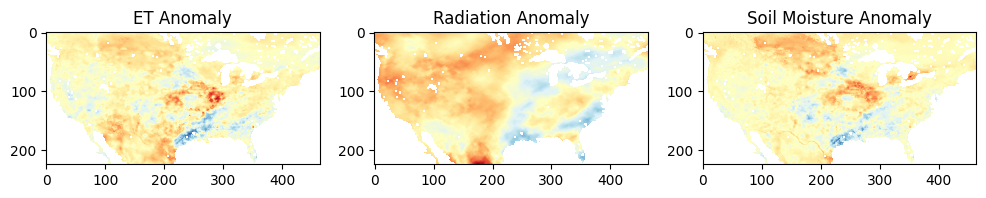

In [92]:
images = [
    et_anomaly[-1],
    rad_anomaly[-1],
    sm_anomaly[-1]
]
labels = ['ET', 'Radiation', 'Soil Moisture']

fig = pyplot.figure(figsize = (12, 5))
ax = fig.subplots(1, 3)
for i in range(3):
    ax[i].imshow(images[i], cmap = 'RdYlBu')
    ax[i].set_title(labels[i] + ' Anomaly')

---

## Bringing in NASA Earth Observations

The NLDAS data we've used are a great tool for retrospective studies but, as a re-analysis dataset, it has some limitations:

- It has a relatively high latency; it may be days or weeks before data are available.
- It integrates data from multiple sources but with varying levels of accuracy and geographic coverage.

If we want to characterize flash drought or detect it in near-real time, we shouldn't use re-analysis datasets. Instead, we want some kind of direct observation of drought conditions. **Let's see what we can learn about the 2017 Flash Drought from NASA's satellite-based soil-moisture estimates.**

**We'll use data from NASA's Soil Moisture Active Passive (SMAP) Mission.** [NASA's earth observing missions provide data that is grouped into different processing levels:](https://www.earthdata.nasa.gov/engage/open-data-services-and-software/data-information-policy/data-levels)

- **Level 1 (Raw data):** Basically, these are data values measured directly by a satellite instrument. They may or may not be physically interpretable. Most end-users won't benefit from Level 1 data.
- **Level 2:** These are physically interpretable values that have been derived from the raw data, at the same spatial and temporal resolution as the Level 1 data. Level 2 data may be hard to use because the spatial structure of the data matches the instrument's viewing geometry.
- **Level 3:** At Level 3, the geophysical values have been standardized on a uniform spatial grid and uniform time series. While some values may be missing due to low quality, clouds, or sensor failure, gridded Level 3 data from different time steps can be easily combined and compared.
- **Level 4 (Model-enhanced data):** At Level 4, the values from Level 3 data are incorporated into some kind of model, possibly combining additional, independent datasets from other sensors in order to produce enhanced estimates or analyses of geophysical variables.

### Downloading and Documenting the Data

**[We'll use the 36-km Level 3 surface soil moisture data from the SMAP mission](https://nsidc.org/data/spl3smp/versions/8)** because these are a good compromise between direct sensor observations and ease of use.

- At the website above, we can see there are multiple ways of accessing the data. [Let's use Earthdata Search;](https://search.earthdata.nasa.gov/search?q=SPL3SMP+V008) can we access the data from NASA's cloud using `earthaccess`?
- You may have noticed that the Level 3 SMAP data we want to use are *not* "Available in Earthdata Cloud." It looks like we'll have to download the data directly.
- **Where will we put the raw data we download?** Let's revisit our file tree in Jupyter Notebook.
- **Within the `data_raw` folder, let's create a new folder called `SMAP_L3`.** This is where we'll put the data we're about to download.

We've discussed the importance of having a well-documented workflow that makes it easy to understand how we obtained a particular scientific result. We assume that we can re-download the raw data we used anytime, but what if we forget where the data came from? Since the SMAP Level 3 data aren't available in the Cloud, we're about to do download the data manually, and it would be a good idea to document what steps we took to do that, in case there are questions about where the data came from or what kind of processing was applied.

- In the Jupyter Notebook file tree, within the `SMAP_L3` folder let's make a new `"New File"`. Name the new text file `README.txt`.
- Double-click `README.txt` to open it. This is where we'll add some useful information about the data we're about to download. Below is an example.

```
Author: K. Arthur Endsley
Date: November 1, 2023

This folder contains Level 3 data from the SMAP Mission. It was downloaded from:

    https://search.earthdata.nasa.gov/search?q=SPL3SMP+V008

Here's some more information about this product:

    https://nsidc.org/data/spl3smp/versions/8
```

This might not seem like a lot of information but there's plenty here that we would want to know if we took a long break from this project or if someone else had to try and figure out what we were doing. And its short length is also an advantage: **documenting your project doesn't have to be hard and any amount of information is better than none.**

### Customizing an Earthdata Search Download

The SMAP satellite has two overpasses every day, a "morning" and an "afternoon" overpass (local time). Let's use soil moisture data from the afternoon (PM) overpass, because this is likely when soil moisture stress on vegetation is at its peak.

- [**This link will get you to the right place to start.**](https://search.earthdata.nasa.gov/search?q=SPL3SMP%20V008) Click on the one dataset that is shown on the right-hand side of the search window.
- We'll download data from August and September to study the onset and progression of the 2017 Flash Drought: **Choose a temporal subset, 2017-06-01 through 2017-09-30.**
- At the bottom right, **click the big green button that reads "Download All."**
- 3.8 GB is a lot of data! Can we make this download any smaller? We're only interested in soil moisture from the afternoon overpass. **Click "Edit Options" and under "Select a data access method," select the "Customize" option.**

![](assets/M1_Earthdata_Search_SMAP-L3_customize_order.png)

- **Scroll down to "Configure data customization options" and down to "Band subsetting."**
- **Within the text box that reads "Filter" type `soil_moisture_dca_pm`.** This will filter the available variables ("bands") to just this specific variable, which is the soil moisture estimate from the Dual-Channel Algorithm (DCA) for the afternoon (PM) overpass.
- To make sure that `soil_moisture_dca_pm` is the *only* variable we download, **you'll need to uncheck the box next to `SPL3SMP` then re-check the box next to `soil_moisture_dca_pm` (see screenshot below).**

![](assets/M1_Earthdata_Search_SMAP-L3_customize_order_variables.png)
  
- Hit "Done" at the bottom of this form then the big green button that reads "Download Data"!

#### But Wait!

Because we selected a subset of variables, we'll have to wait to get an e-mail that the order is ready. **You don't need to do these steps yourself, because I already prepared all the data granules that would be downloaded this way.** They can be download directly from here:

- [SMAP_L3_SPL3SMP_V008_20170601_20170930.zip](http://files.ntsg.umt.edu/data/ScienceCore/SMAP_L3_SPL3SMP_V008_20170601_20170930.zip) (Extract this ZIP file's contents to your `data_raw/SMAP_L3` folder)

--- 

## Reading SMAP Level 3 Data

The SMAP Level 3 data we downloaded are each stored as a **Hierarchical Data File, version 5 (HDF5).**

In [ ]:
import h5py

hdf = h5py.File('data_raw/SMAP_L3/SMAP_L3_SM_P_20170901_R18290_001_HEGOUT.h5', 'r')
hdf

An HDF5 file is a lot like a netCDF4 file: they are both hierarhical files capable of storing multiple, diverse datasets and metadata in a single file. What do we mean by "hierarchical"? Well, an HDF5 or netCDF4 file is like a file tree, where *datasets* can be organized into different nested *groups,* as depicted below. Metadata, in the form of *attributes,* can be attached to any dataset or group throughout the file.

![](assets/hdf5-structure.jpg)

*Image courtesy of NEON Science.*

In [ ]:
hdf.keys()

In [ ]:
hdf['Metadata']

In [ ]:
hdf['Metadata'].keys()

In [ ]:
# TODO Significance of an empty group?
hdf['Metadata/ProcessStep']

In [ ]:
hdf['Metadata/ProcessStep'].attrs.keys()

In [ ]:
hdf['Metadata/ProcessStep'].attrs['softwareTitle']

### Reading HDF5 Datasets

In [ ]:
filename = 'data_raw/SMAP_L3/SMAP_L3_SM_P_20170901_R18290_001_HEGOUT.h5'

hdf = h5py.File(filename, 'r')
hdf.keys()

In [ ]:
# TODO Remark on importance of closing a file

hdf.close()

In [ ]:
# TODO Explain that we'd like to open the file with xarray
# TODO Note there are no coordinates

ds = xr.open_dataset(filename, group = 'Soil_Moisture_Retrieval_Data_PM')
ds

In [ ]:
# TODO Note coordinates assignment

ds = ds.assign_coords({'x': hdf['x'][:], 'y': hdf['y'][:]})
ds

In [ ]:
# TODO Remark on striping

pyplot.figure(figsize = (12, 5))
ds['soil_moisture_dca_pm'].plot()

### Challenge: Write a Function to Process SMAP L3 Data

Based on what we just did above, write a single function that:

- Accepts a file path to a SMAP L3 `*.h5` file, as a Python string
- Returns an `xr.Dataset`

In [ ]:
def process_smap_l3(file_path):
    '''
    Parameters
    ----------
    file_path : str
        The file path to the SMAP L3 file

    Returns
    -------
    xarray.Dataset
    '''
    with h5py.File(file_path, 'r') as hdf:
        ds = xr.open_dataset(file_path, group = 'Soil_Moisture_Retrieval_Data_PM')
        return ds.assign_coords({'x': hdf['x'][:], 'y': hdf['y'][:]})

In [ ]:
from pyl4c.ease2 import ease2_from_wgs84

help(ease2_from_wgs84)

In [ ]:
# We want the upper-left corner coordinates
upper_left = ease2_from_wgs84((-109, 49), grid = 'M36')
upper_left

In [ ]:
lower_right = ease2_from_wgs84((-95, 43), grid = 'M36')
lower_right

In [ ]:
ds = process_smap_l3('data_raw/SMAP_L3/SMAP_L3_SM_P_20170801_R18290_001_HEGOUT.h5')

In [ ]:
ds['soil_moisture_dca_pm'][49:59,187:227].plot()

In [ ]:
ds['soil_moisture_dca_pm'][49:59,187:227].mean().values

In [ ]:
# TODO Note the importance of sorting the files!

file_list = glob.glob('data_raw/SMAP_L3/*.h5')
file_list[0]

In [ ]:
file_list.sort()
file_list[0]

In [ ]:
upper_left = ease2_from_wgs84((-109, 49), grid = 'M36')
lower_right = ease2_from_wgs84((-97, 43), grid = 'M36')
r0, c0 = upper_left
r1, c1 = lower_right

sm_mean = []
for filename in file_list:
    ds = process_smap_l3(filename)
    sm_mean.append(ds['soil_moisture_dca_pm'][r0:r1,c0:c1].mean().values)

sm_mean = np.hstack(sm_mean)

In [ ]:
dates = pandas.date_range('2017-06-01', '2017-09-30', freq = '1D')
dates

In [ ]:
# TODO Talk about: 1) The gaps; 2) The oscillations; 3) The increase in soil moisture after Sept. 15

pyplot.figure(figsize = (10, 5))
pyplot.plot(dates, sm_mean, 'k-')
pyplot.ylabel('Volumetric Soil Moisture (m3 m-3)')
pyplot.show()

### Calculating a Moving Average

One way to address the gaps might be to calculate a moving average, filling in missing values for a given date with the average of the values from adjacent dates.

In [ ]:
time_series = []

for i in range(len(file_list)):
    # Skip the first and last files
    if i == 0 or i == (len(file_list) - 1):
        continue

    # For the previous, current, and next dates...
    sm_stack = []
    for j in [i-1, i, i+1]:
        ds = process_smap_l3(file_list[j])
        sm = ds['soil_moisture_dca_pm'][r0:r1,c0:c1]
        sm_stack.append(sm)

    # Take the average of the 3 values in each pixel, excluding NaNs
    sm_stack = np.nanmean(np.stack(sm_stack, axis = 0), axis = 0)
    # Then, compute the overall mean for the region of interest
    time_series.append(sm_stack.mean())

In [ ]:
len(time_series)

In [ ]:
pyplot.imshow(sm_stack)

In [ ]:
pyplot.figure(figsize = (10, 5))
pyplot.plot(dates[1:-1], time_series, 'k-')
pyplot.ylabel('Volumetric Soil Moisture (m3 m-3)')
pyplot.show()

### Summary: Reading HDF5 and netCDF4 Files

|                            |  HDF5                              | netCDF4                                | `xarray` (for both)        |
|:---------------------------|:-----------------------------------|:---------------------------------------|:---------------------------|
|Module import               | `import h5py`                      | `import netCDF4`                       | `import xarray as xr`      |
|Files opened with...        | `hdf = h5py.File(...)`             | `nc = netCDF4.Dataset()`               | `ds = xr.open_dataset()`   |
|Datasets/groups viewed...   | `hdf.keys()`                       | `nc.variables` or `nc.variables.keys()`| `list(ds.variables.keys())`|
|                            | `hdf['group_name'].keys()`         | `nc.variables['group_name'].keys()`    |                            |
|Datasets accessed through...| `hdf`                              | `nc.variables`                         | `ds.variables`             |
|Attributes listed through...| `hdf.attrs`                        | `nc.ncattrs()`                         | `ds.attrs`                 |
|                            | `hdf['dataset'].attrs`             | `nc.variables['dataset'].ncattrs()`    |                            |
|Attributes read by...       | `hdf['dataset'].attrs['attribute']`| `nc.variables['dataset'].getncattr()`  | `ds.variables['dataset']`  |

---

## More Resources

- Curious about how to use `earthaccess.open()` along with `xarray` so that you don't have keep any downloaded files around? Well, `xarray.open_dataset()` can be slow when you have a lot of files to open, as in this time-series example. [This article describes how you can speed up `xarray.open_dataset()`](https://climate-cms.org/posts/2018-09-14-dask-era-interim.html) when working with multiple cloud-hosted files.